# GPU

In [1]:
#@title Titre par défaut
import numpy as np
np.random.seed(1000)


import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


import tensorflow as tf
import timeit

Found GPU at: /device:GPU:0


# Import

In [2]:
#@title Titre par défaut
import numpy as np
np.random.seed(1000)
import tensorflow as tf
import timeit
# https://keras.io/
!pip install -q keras
import keras

!pip install -q tqdm
import tqdm

Using TensorFlow backend.


In [0]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.optimizers import Adam, Adagrad
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from tqdm import tqdm
tqdm.monitor_interval = 0

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, UpSampling2D, MaxPooling2D
from keras.datasets import mnist
from keras.optimizers import Adam, Adagrad
from keras import backend as K
from keras import initializers
from keras.utils import np_utils

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Convolution2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers

K.set_image_dim_ordering('tf')

# Deterministic output.
# Tired of seeing the same results every time? Remove the line below.
np.random.seed(1000)

# The results are a little better when the dimensionality of the random vector is only 10.
# The dimensionality has been left at 100 for consistency with other GAN implementations.
randomDim = 100
K.set_image_dim_ordering('th')

# Deterministic output.
# Tired of seeing the same results every time? Remove the line below.

# The results are a little better when the dimensionality of the random vector is only 10.
# The dimensionality has been left at 100 for consistency with other GAN implementations.
randomDim = 100


# RBF

In [0]:
from keras.engine import InputSpec, Layer
from keras.legacy import interfaces
#@title COUCHES RBF
###________TROIS CLASSES POUR IMPLEMENTER DES COUCHES RBF________###

class RBFLayer(Layer):
    def __init__(self, alpha=1000.0, alpha_initializer='zeros',
                 alpha_regularizer=None,
                 alpha_constraint=None, 
                 **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.supports_masking = True
        self.supports_masking = True
        self.alpha_initializer = keras.initializers.Constant(value=1000.0)
        self.alpha_regularizer = regularizers.get(alpha_regularizer)
        self.alpha_constraint = constraints.get(alpha_constraint)
        self.alpha = self.add_weight(shape=(1,),
                                     name='alpha',
                                     initializer=self.alpha_initializer,
                                     regularizer=self.alpha_regularizer,
                                     constraint=self.alpha_constraint)
        self.trainable = False

    def call(self, inputs):
        y = - inputs / self.alpha[0]
        y = keras.backend.exp(y)
        return y

    def get_config(self):
        config = {
            'alpha_initializer': initializers.serialize(self.alpha_initializer),
            'alpha_regularizer': regularizers.serialize(self.alpha_regularizer),
            'alpha_constraint': constraints.serialize(self.alpha_constraint),
            'shared_axes': self.shared_axes
        }
        base_config = super(RBFLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

class RBF(Layer):
    @interfaces.legacy_dense_support
    def __init__(self, units,
                 activation=None,
                 use_bias=False,
                 kernel_initializer='TruncatedNormal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 sigma = 1000.0,
                 **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(RBF, self).__init__(**kwargs)
        self.units = units
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.sigma = sigma
        self.input_spec = InputSpec(min_ndim=2)
        self.supports_masking = True

    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]

        self.kernel = self.add_weight(shape=(input_dim, self.units),
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True

    def call(self, inputs):
        norm_x = K.transpose(K.sum(inputs * inputs , axis=1))
        norm_w = K.sum(self.kernel *self.kernel , axis=0)
        norm_x = keras.backend.expand_dims(norm_x, axis=-1)
        prod_scal = -2 * K.dot(inputs, self.kernel)
        print ("Shapes : ", norm_x.shape, norm_w.shape, prod_scal.shape) 
        a = tf.add(norm_x, prod_scal) # -2 *  prod_scal)
        y = tf.add(a, norm_w )
        y = - y / self.sigma
        y = keras.backend.exp(y)
        return y

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) >= 2
        assert input_shape[-1]
        output_shape = list(input_shape)
        output_shape[-1] = self.units
        return tuple(output_shape)

    def get_config(self):
        config = {
            'units': self.units,
            'activation': activations.serialize(self.activation),
            'use_bias': self.use_bias,
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'bias_initializer': initializers.serialize(self.bias_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': regularizers.serialize(self.bias_regularizer),
            'activity_regularizer': regularizers.serialize(self.activity_regularizer),
            'kernel_constraint': constraints.serialize(self.kernel_constraint),
            'bias_constraint': constraints.serialize(self.bias_constraint)
        }
        base_config = super(RBF, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

class RBF2(Layer):
    @interfaces.legacy_dense_support
    def __init__(self, units,
                 activation=None,
                 use_bias=False,
                 kernel_initializer='TruncatedNormal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(RBF2, self).__init__(**kwargs)
        self.units = units
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.input_spec = InputSpec(min_ndim=2)
        self.supports_masking = True

    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]
        self.kernel = self.add_weight(shape=(input_dim, self.units),
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True

    def call(self, inputs):
        norm_x = K.transpose(K.sum(inputs * inputs , axis=1))
        norm_w = K.sum(self.kernel *self.kernel , axis=0)
        norm_x = keras.backend.expand_dims(norm_x, axis=-1)
        prod_scal = -2 * K.dot(inputs, self.kernel)
        print ("Shapes : ", norm_x.shape, norm_w.shape, prod_scal.shape) 
        a = tf.add(norm_x, prod_scal) # -2 *  prod_scal)
        y = tf.add(a, norm_w )
        return y

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) >= 2
        assert input_shape[-1]
        output_shape = list(input_shape)
        output_shape[-1] = self.units
        return tuple(output_shape)

    def get_config(self):
        config = {
            'units': self.units,
            'activation': activations.serialize(self.activation),
            'use_bias': self.use_bias,
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'bias_initializer': initializers.serialize(self.bias_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': regularizers.serialize(self.bias_regularizer),
            'activity_regularizer': regularizers.serialize(self.activity_regularizer),
            'kernel_constraint': constraints.serialize(self.kernel_constraint),
            'bias_constraint': constraints.serialize(self.bias_constraint)
        }
        base_config = super(RBF2, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

# Base de données selon un seuil

In [0]:


# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#2. Get the file
downloaded = drive.CreateFile({'id':'1eyJdoywF4ZLygiQCrC-xfFVPXWr3wRDc'}) # replace the id with id of file you want to access
downloaded.GetContentFile('dossier1.csv')  

#3. Read file as panda dataframe
import pandas as pd
dossier1 = pd.read_csv('dossier1.csv') 

In [0]:
seuil=0.4
good_examples=dossier1[(dossier1.resultat<seuil)]

good_examples=good_examples.drop(['resultat'],axis=1)

In [46]:
good_examples=good_examples.reset_index()
#good_examples=good_examples.drop(['level_0'],axis=1)
good_examples=good_examples.drop(['index'],axis=1)
good_examples.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,-0.978988,-0.997600,-0.999640,-0.999894,-0.999955,-0.999969,-0.999977,-0.999961,-0.999836,-0.999266,...,-0.999965,-0.999780,-0.999872,-0.999975,-0.999995,-0.999999,-0.999999,-0.999995,-0.999847,-0.998497
1,-0.994117,-0.999061,-0.999680,-0.999607,-0.999583,-0.999690,-0.999836,-0.999782,-0.999641,-0.999380,...,-0.999986,-0.999947,-0.999945,-0.999865,-0.999912,-0.999981,-0.999985,-0.999990,-0.999853,-0.997946
2,-0.931731,-0.994977,-0.999821,-0.999973,-0.999956,-0.999875,-0.999370,-0.998180,-0.998704,-0.999125,...,-0.999962,-0.999988,-0.999971,-0.999818,-0.999542,-0.997993,-0.999163,-0.999866,-0.999650,-0.998835
3,-0.981547,-0.995573,-0.997646,-0.997123,-0.996884,-0.998384,-0.999608,-0.999737,-0.999745,-0.998895,...,-0.998766,-0.994884,-0.999374,-0.999954,-0.999988,-0.999998,-0.999991,-0.999941,-0.998706,-0.985937
4,-0.984444,-0.997646,-0.999387,-0.999382,-0.999391,-0.999594,-0.999842,-0.999927,-0.999932,-0.999881,...,-0.999998,-0.999995,-0.999995,-0.999997,-0.999996,-0.999999,-0.999998,-0.999990,-0.999742,-0.996258


In [0]:
good_examples['target']=0.9

In [0]:
# Load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = (X_train.astype(np.float32) - 127.5)/127.5

X_test = (X_test.astype(np.float32) - 127.5)/127.5

In [0]:
xyz=pd.DataFrame(X_train.reshape(60000,28*28))


In [0]:
xyz['target']=0


In [51]:
good_examples.shape

(31686, 785)

In [0]:
xyz.columns=good_examples.columns

In [0]:
xyz=pd.concat([xyz,good_examples],axis=0)

In [0]:
from sklearn.utils import shuffle
xyz=shuffle(xyz)

In [55]:
xyz.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,target
59307,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0
40418,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0
36534,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0
6988,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0
14840,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0


# rejector with 1 output

In [0]:
K.set_image_dim_ordering('tf')


In [0]:
# Load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

nb_classes = 10
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train[:, :, :, np.newaxis]

Y_train = np_utils.to_categorical(y_train, nb_classes)
#Y_train = Y_train * 0.9

X_test = (X_test.astype(np.float32) - 127.5)/127.5
X_test = X_test[:, :, :,np.newaxis ]
Y_test = np_utils.to_categorical(y_test, nb_classes)
#Y_test = Y_test * 0.9

In [58]:
########################################"True"
from keras import activations, initializers, regularizers, constraints,metrics
from keras.optimizers import Adam, Adagrad
adagrad = Adagrad(lr=0.001, epsilon=None, decay=0.0) #c'est celui-là qui est utilisé pour tous les modèles


# Rejector
rejector= Sequential()
rejector.add(Conv2D(64, kernel_size=(3, 3), padding='same', input_shape=(28, 28,1),activation='relu'))
rejector.add(MaxPooling2D(pool_size=(3, 3)))
rejector.add(Conv2D(128, (3, 3), activation='relu') )
rejector.add(MaxPooling2D(pool_size=(3, 3)) )
rejector.add(Dropout(0.25))
rejector.add(Flatten())
rejector.add(Dense(128, activation='relu'))
rejector.add(RBF2(300) )
rejector.add(RBFLayer(alpha=2000.0) )
rejector.add(Dense(1, activation='sigmoid', name='r_output', use_bias=False))


rejector.compile(optimizer=adagrad, loss= 'mse', metrics=['acc'])  #  metrics=['acc', f1, precision, recall])
rejector.summary()

('Shapes : ', TensorShape([Dimension(None), Dimension(1)]), TensorShape([Dimension(300)]), TensorShape([Dimension(None), Dimension(300)]))
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 2, 2, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)               0         
___

In [0]:
from sklearn.model_selection import train_test_split
xyz_train,xyz_val=train_test_split(xyz,test_size=0.2)
y_train=xyz_train.target.values
x_train=xyz_train.drop(['target'],axis=1)
y_val=xyz_val.target.values
x_val=xyz_val.drop(['target'],axis=1)

In [0]:
x_train=x_train.values.astype('float32').reshape(x_train.shape[0],28,28,1)
x_val=x_val.values.astype('float32').reshape(x_val.shape[0],28,28,1)

In [61]:
from keras.callbacks import ReduceLROnPlateau
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

epochs = 50 
batch_size = 60
rejector.fit(x_train, y_train, nb_epoch=epochs, batch_size=batch_size, callbacks=[learning_rate_reduction],validation_data = (x_val, y_val))

Train on 73348 samples, validate on 18338 samples
Epoch 1/50
73348/73348 [==============================] - 20s 275us/step - loss: 0.1816 - acc: 0.6522 - val_loss: 0.1765 - val_acc: 0.6586
Epoch 2/50
44400/73348 [=================>............] - ETA: 7s - loss: 0.1749 - acc: 0.6573

73348/73348 [==============================] - 20s 273us/step - loss: 0.1744 - acc: 0.6534 - val_loss: 0.1701 - val_acc: 0.6586
Epoch 3/50
73348/73348 [==============================] - 20s 271us/step - loss: 0.1681 - acc: 0.6534 - val_loss: 0.1638 - val_acc: 0.6586
Epoch 4/50
11520/73348 [===>..........................] - ETA: 16s - loss: 0.1646 - acc: 0.6540

73348/73348 [==============================] - 20s 278us/step - loss: 0.1625 - acc: 0.6534 - val_loss: 0.1585 - val_acc: 0.6586

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.000500000023749.
Epoch 5/50
60000/73348 [=======================>......] - ETA: 3s - loss: 0.1590 - acc: 0.6531

73348/73348 [==============================] - 20s 273us/step - loss: 0.1587 - acc: 0.6534 - val_loss: 0.1563 - val_acc: 0.6586
Epoch 6/50
73348/73348 [==============================] - 20s 273us/step - loss: 0.1565 - acc: 0.6534 - val_loss: 0.1543 - val_acc: 0.6586
Epoch 7/50
14760/73348 [=====>........................] - ETA: 14s - loss: 0.1557 - acc: 0.6560

73348/73348 [==============================] - 20s 271us/step - loss: 0.1548 - acc: 0.6534 - val_loss: 0.1526 - val_acc: 0.6586

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.000250000011874.
Epoch 8/50
61200/73348 [========================>.....] - ETA: 3s - loss: 0.1539 - acc: 0.6529

73348/73348 [==============================] - 20s 273us/step - loss: 0.1535 - acc: 0.6534 - val_loss: 0.1518 - val_acc: 0.6586
Epoch 9/50
73348/73348 [==============================] - 20s 272us/step - loss: 0.1529 - acc: 0.6534 - val_loss: 0.1511 - val_acc: 0.6586
Epoch 10/50
15900/73348 [=====>........................] - ETA: 14s - loss: 0.1526 - acc: 0.6533

73348/73348 [==============================] - 20s 273us/step - loss: 0.1522 - acc: 0.6534 - val_loss: 0.1505 - val_acc: 0.6586

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.000125000005937.
Epoch 11/50
61200/73348 [========================>.....] - ETA: 3s - loss: 0.1518 - acc: 0.6538

73348/73348 [==============================] - 20s 272us/step - loss: 0.1518 - acc: 0.6534 - val_loss: 0.1501 - val_acc: 0.6586
Epoch 12/50
73348/73348 [==============================] - 20s 271us/step - loss: 0.1515 - acc: 0.6534 - val_loss: 0.1499 - val_acc: 0.6586
Epoch 13/50
16020/73348 [=====>........................] - ETA: 14s - loss: 0.1503 - acc: 0.6569

73348/73348 [==============================] - 20s 272us/step - loss: 0.1512 - acc: 0.6534 - val_loss: 0.1496 - val_acc: 0.6586

Epoch 00013: ReduceLROnPlateau reducing learning rate to 6.25000029686e-05.
Epoch 14/50
60840/73348 [=======================>......] - ETA: 3s - loss: 0.1510 - acc: 0.6527

73348/73348 [==============================] - 20s 273us/step - loss: 0.1510 - acc: 0.6534 - val_loss: 0.1495 - val_acc: 0.6586
Epoch 15/50
73348/73348 [==============================] - 20s 271us/step - loss: 0.1509 - acc: 0.6534 - val_loss: 0.1493 - val_acc: 0.6586
Epoch 16/50
15600/73348 [=====>........................] - ETA: 14s - loss: 0.1507 - acc: 0.6537

73348/73348 [==============================] - 20s 270us/step - loss: 0.1508 - acc: 0.6534 - val_loss: 0.1492 - val_acc: 0.6586

Epoch 00016: ReduceLROnPlateau reducing learning rate to 3.12500014843e-05.
Epoch 17/50
61620/73348 [========================>.....] - ETA: 2s - loss: 0.1504 - acc: 0.6543

73348/73348 [==============================] - 20s 270us/step - loss: 0.1506 - acc: 0.6534 - val_loss: 0.1492 - val_acc: 0.6586
Epoch 18/50
73348/73348 [==============================] - 20s 273us/step - loss: 0.1505 - acc: 0.6534 - val_loss: 0.1491 - val_acc: 0.6586
Epoch 19/50
15840/73348 [=====>........................] - ETA: 14s - loss: 0.1494 - acc: 0.6568

73348/73348 [==============================] - 20s 272us/step - loss: 0.1505 - acc: 0.6534 - val_loss: 0.1490 - val_acc: 0.6586

Epoch 00019: ReduceLROnPlateau reducing learning rate to 1.56250007421e-05.
Epoch 20/50
61740/73348 [========================>.....] - ETA: 2s - loss: 0.1506 - acc: 0.6532

73348/73348 [==============================] - 20s 272us/step - loss: 0.1505 - acc: 0.6534 - val_loss: 0.1490 - val_acc: 0.6586
Epoch 21/50
73348/73348 [==============================] - 20s 273us/step - loss: 0.1504 - acc: 0.6534 - val_loss: 0.1490 - val_acc: 0.6586
Epoch 22/50
15840/73348 [=====>........................] - ETA: 14s - loss: 0.1504 - acc: 0.6537

73348/73348 [==============================] - 20s 271us/step - loss: 0.1504 - acc: 0.6534 - val_loss: 0.1490 - val_acc: 0.6586

Epoch 00022: ReduceLROnPlateau reducing learning rate to 1e-05.
Epoch 23/50
63960/73348 [=========================>....] - ETA: 2s - loss: 0.1506 - acc: 0.6527

73348/73348 [==============================] - 20s 272us/step - loss: 0.1503 - acc: 0.6534 - val_loss: 0.1490 - val_acc: 0.6586
Epoch 24/50
73348/73348 [==============================] - 20s 272us/step - loss: 0.1505 - acc: 0.6534 - val_loss: 0.1489 - val_acc: 0.6586
Epoch 25/50
16680/73348 [=====>........................] - ETA: 14s - loss: 0.1488 - acc: 0.6578

73348/73348 [==============================] - 20s 273us/step - loss: 0.1505 - acc: 0.6534 - val_loss: 0.1489 - val_acc: 0.6586
Epoch 26/50
73348/73348 [==============================] - 20s 270us/step - loss: 0.1504 - acc: 0.6534 - val_loss: 0.1489 - val_acc: 0.6586
Epoch 27/50
 6000/73348 [=>............................] - ETA: 16s - loss: 0.1503 - acc: 0.6518

73348/73348 [==============================] - 20s 272us/step - loss: 0.1503 - acc: 0.6534 - val_loss: 0.1489 - val_acc: 0.6586
Epoch 28/50
73348/73348 [==============================] - 20s 271us/step - loss: 0.1503 - acc: 0.6534 - val_loss: 0.1489 - val_acc: 0.6586
Epoch 29/50
 3000/73348 [>.............................] - ETA: 18s - loss: 0.1516 - acc: 0.6497

73348/73348 [==============================] - 20s 273us/step - loss: 0.1504 - acc: 0.6534 - val_loss: 0.1489 - val_acc: 0.6586
Epoch 30/50
73348/73348 [==============================] - 20s 274us/step - loss: 0.1503 - acc: 0.6534 - val_loss: 0.1489 - val_acc: 0.6586
Epoch 31/50
 2400/73348 [..............................] - ETA: 17s - loss: 0.1492 - acc: 0.6629

73348/73348 [==============================] - 20s 271us/step - loss: 0.1502 - acc: 0.6534 - val_loss: 0.1488 - val_acc: 0.6586
Epoch 32/50
73348/73348 [==============================] - 20s 271us/step - loss: 0.1503 - acc: 0.6534 - val_loss: 0.1488 - val_acc: 0.6586
Epoch 33/50
 2340/73348 [..............................] - ETA: 18s - loss: 0.1517 - acc: 0.6517

73348/73348 [==============================] - 20s 272us/step - loss: 0.1503 - acc: 0.6534 - val_loss: 0.1488 - val_acc: 0.6586
Epoch 34/50
73348/73348 [==============================] - 20s 274us/step - loss: 0.1503 - acc: 0.6534 - val_loss: 0.1488 - val_acc: 0.6586
Epoch 35/50
 1980/73348 [..............................] - ETA: 17s - loss: 0.1559 - acc: 0.6354

73348/73348 [==============================] - 20s 272us/step - loss: 0.1503 - acc: 0.6534 - val_loss: 0.1488 - val_acc: 0.6586
Epoch 36/50
73348/73348 [==============================] - 20s 272us/step - loss: 0.1502 - acc: 0.6534 - val_loss: 0.1488 - val_acc: 0.6586
Epoch 37/50
 2220/73348 [..............................] - ETA: 17s - loss: 0.1523 - acc: 0.6423

73348/73348 [==============================] - 20s 272us/step - loss: 0.1502 - acc: 0.6534 - val_loss: 0.1488 - val_acc: 0.6586
Epoch 38/50
73348/73348 [==============================] - 20s 273us/step - loss: 0.1501 - acc: 0.6534 - val_loss: 0.1487 - val_acc: 0.6586
Epoch 39/50
 1980/73348 [..............................] - ETA: 17s - loss: 0.1495 - acc: 0.6556

73348/73348 [==============================] - 20s 272us/step - loss: 0.1502 - acc: 0.6534 - val_loss: 0.1487 - val_acc: 0.6586
Epoch 40/50
73348/73348 [==============================] - 20s 273us/step - loss: 0.1502 - acc: 0.6534 - val_loss: 0.1487 - val_acc: 0.6586
Epoch 41/50
 1860/73348 [..............................] - ETA: 18s - loss: 0.1506 - acc: 0.6452

73348/73348 [==============================] - 20s 270us/step - loss: 0.1502 - acc: 0.6534 - val_loss: 0.1487 - val_acc: 0.6586
Epoch 42/50
73348/73348 [==============================] - 20s 271us/step - loss: 0.1503 - acc: 0.6534 - val_loss: 0.1487 - val_acc: 0.6586
Epoch 43/50
 2400/73348 [..............................] - ETA: 17s - loss: 0.1486 - acc: 0.6671

73348/73348 [==============================] - 20s 270us/step - loss: 0.1503 - acc: 0.6534 - val_loss: 0.1487 - val_acc: 0.6586
Epoch 44/50
73348/73348 [==============================] - 20s 271us/step - loss: 0.1501 - acc: 0.6534 - val_loss: 0.1487 - val_acc: 0.6586
Epoch 45/50
 2640/73348 [>.............................] - ETA: 17s - loss: 0.1546 - acc: 0.6439

73348/73348 [==============================] - 20s 270us/step - loss: 0.1503 - acc: 0.6534 - val_loss: 0.1487 - val_acc: 0.6586
Epoch 46/50
73348/73348 [==============================] - 20s 269us/step - loss: 0.1502 - acc: 0.6534 - val_loss: 0.1487 - val_acc: 0.6586
Epoch 47/50
 2940/73348 [>.............................] - ETA: 17s - loss: 0.1487 - acc: 0.6612

73348/73348 [==============================] - 20s 270us/step - loss: 0.1501 - acc: 0.6534 - val_loss: 0.1486 - val_acc: 0.6586
Epoch 48/50
73348/73348 [==============================] - 20s 269us/step - loss: 0.1502 - acc: 0.6534 - val_loss: 0.1486 - val_acc: 0.6586
Epoch 49/50
 2940/73348 [>.............................] - ETA: 17s - loss: 0.1462 - acc: 0.6571

73348/73348 [==============================] - 20s 270us/step - loss: 0.1501 - acc: 0.6534 - val_loss: 0.1486 - val_acc: 0.6586
Epoch 50/50
73348/73348 [==============================] - 20s 274us/step - loss: 0.1499 - acc: 0.6534 - val_loss: 0.1486 - val_acc: 0.6586


In [0]:
y_pred=rejector.predict(x_val)

In [0]:
Y_pred=[]
Y_val=[]
for i in range (y_pred.shape[0]):
  Y_pred.append(y_pred[i].item())
  if y_val[i].item() !=0:
    Y_val.append(1)
  else:
    Y_val.append(0)


In [0]:
from sklearn.metrics import roc_curve,auc
fpr,tpr,_=roc_curve(Y_val, Y_pred)
roc_auc=auc(fpr,tpr)

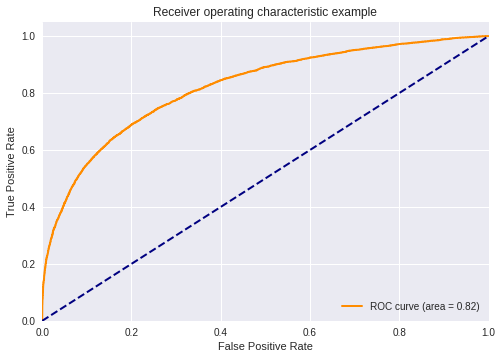

In [65]:
#seuil=0.2
import matplotlib.pyplot as plt
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [0]:
y_rej_pred=rejector.predict(X_test)

In [67]:
max(y_rej_pred)

array([0.49590588], dtype=float32)

In [68]:
##### dessiner en fonction des seuil 
Point=[]
for j in range (1,500):
  Y_test_new=[]
  X_test_new=[]
  Y_rejet_new=[]
  X_rejet_new=[]

  for i in range(len (y_rej_pred)): 
    if y_rej_pred[i].item()<=float(j)/1000: 
      X_test_new.append(X_test[i,:,:,:])
      Y_test_new.append(y_test[i])  
    else:
      X_rejet_new.append(X_test[i,:,:,:])
      Y_rejet_new.append(y_test[i])  
    
  X_test_new=np.reshape(X_test_new, (len(X_test_new),28,28,1))
  X_rejet_new=np.reshape(X_rejet_new, (len(X_rejet_new),28,28,1))
  Y_rejet_new=np.array(Y_rejet_new)
  Y_test_new=np.array(Y_test_new)

  Y_test_new = np_utils.to_categorical(Y_test_new, 10)
  Y_rejet_new = np_utils.to_categorical(Y_rejet_new, 10)


  if Y_test_new.shape!=(0,):
    liste=model_95.evaluate(X_test_new,Y_test_new)
    if liste!=[]:
      Point.append((float(j)/100,liste[1]))
  
  #Point.append(liste[1])
  
  
 # l'AUC



 32/136 [======>.......................] - ETA: 0s

256/607 [===========>..................] - ETA: 0s

 256/1284 [====>.........................] - ETA: 0s

 480/2067 [=====>........................] - ETA: 0s

1536/2830 [===============>..............] - ETA: 0s

2496/3603 [===================>..........] - ETA: 0s

1792/4353 [===========>..................] - ETA: 0s

2304/5004 [============>.................] - ETA: 0s

3808/5631 [===================>..........] - ETA: 0s

1056/6174 [====>.........................] - ETA: 1s

5408/6645 [=======================>......] - ETA: 0s

3552/7095 [==============>...............] - ETA: 0s

 800/7535 [==>...........................] - ETA: 1s

6976/7864 [=========================>....] - ETA: 0s

5760/8175 [====================>.........] - ETA: 0s

4512/8463 [==============>...............] - ETA: 0s

3296/8693 [==========>...................] - ETA: 1s

2048/8908 [=====>........................] - ETA: 1s

1248/9102 [===>..........................] - ETA: 1s

 544/9249 [>.............................] - ETA: 1s

9344/9374 [============================>.] - ETA: 0s

  32/9504 [..............................] - ETA: 1s

9152/9599 [===========================>..] - ETA: 0s

9120/9665 [===========================>..] - ETA: 0s

9184/9738 [===========================>..] - ETA: 0s

9216/9786 [===========================>..] - ETA: 0s

8864/9839 [==========================>...] - ETA: 0s

8576/9868 [=========================>....] - ETA: 0s

8000/9904 [=======================>......] - ETA: 0s

7936/9929 [======================>.......] - ETA: 0s

7840/9947 [======================>.......] - ETA: 0s

7808/9964 [======================>.......] - ETA: 0s

7552/9976 [=====================>........] - ETA: 0s

7776/9986 [======================>.......] - ETA: 0s

7680/9992 [======================>.......] - ETA: 0s

7744/9998 [======================>.......] - ETA: 0s

7936/9999 [======================>.......] - ETA: 0s

7616/9999 [=====================>........] - ETA: 0s

10000/10000 [==============================] - 2s 208us/step


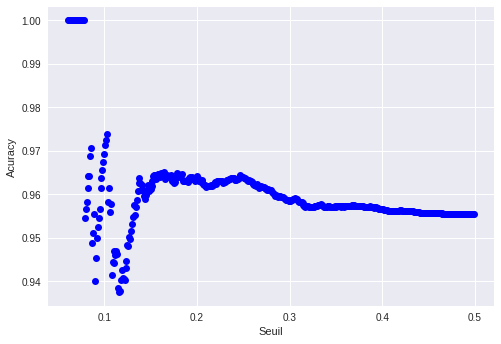

In [69]:
X=[]
Y=[]
for point in Point:
  X.append(point[0]/10)
  Y.append(point[1])
  
plt.xlabel("Seuil")
plt.ylabel("Acuracy")
plt.plot(X,Y,marker='o',color='b',ls='')
plt.show()

In [39]:
from google.colab import files
uploaded = files.upload()

In [40]:
model_95=keras.models.load_model('10_classifier (1)')